In [1]:
# Dependencies
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
# Loading Data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#default dtype for np.empty is np.float64 that's why I'm specifying
training_data_all = np.empty((50000, 3072), dtype = np.uint32)
training_labels = np.empty((50000), dtype = np.uint8)

directory = Path().parent.absolute()

for i in range(1, 6):
    filepath = directory / 'Dataset/cifar-10-batches-py/data_batch_{}'.format(i)
    dictt = unpickle(filepath)
    training_data_all[(i-1)*10000:i*10000] = dictt[b'data']
    training_labels[(i-1)*10000:i*10000] = np.array(dictt[b'labels'])
filepath = directory / 'Dataset/cifar-10-batches-py/test_batch'

dictt = unpickle(filepath)
testing_data = dictt[b'data'].astype(np.uint32)
testing_labels = np.array(dictt[b'labels']).astype(np.uint8)

In [66]:
def predict_label(closest):
    labels_count = np.bincount(closest) #count the labels of the closest k pics
    # all labels are unique ? return the closest label ELSE return the label with the max count (majority vote)
    return closest[0] if labels_count.max() == 1 else np.argmax(labels_count).astype(np.uint8)

In [3]:
#Hyper Parameter (K) Optimization using N-Fold Cross Validation
#Sample training data. Sample Size = 1/5 traning data size
training_data = training_data_all[:10000]
size = len(training_data)

maxK = 15

N = 5    #Number of folds
fold_size = size // N

results = np.empty((maxK+1, N))

# Euclidean Distance : (a-b)^2 = a^2 - 2.b.a + b^2
# a represents training data, b represents validation data in the process of K optimization
pow2 = np.sum(training_data**2, axis = 1)    # Calculate once and reuse for a^2 and b^2
start = time.process_time()
for k in range(1, maxK+1):
    for i in range(N):
        iteration_start = time.process_time()
        print('K = {} \t C.V Fold # {}'.format(k,i))
        #The validation batch of the training data
        bpow2 = pow2[(N-i-1)*fold_size:(N-i)*fold_size]    
        b = training_data[(N-i-1)*fold_size:(N-i)*fold_size]
        # For hiding a validation batch from training data each round using N-Fold C.V
        apow2 = np.ma.array(pow2)
        apow2[(N-i-1)*fold_size:(N-i)*fold_size] = np.ma.masked
        a = np.ma.array(training_data)
        a[(N-i-1)*fold_size:(N-i)*fold_size] = np.ma.masked
        #calculating euclidean distance
        bxax2 = 2 * np.ma.dot(b, a.T) #shape : (2000,10000)
        distancesqrd = apow2 - bxax2 + bpow2[:, np.newaxis] # (10000,) + (2000,10000) + (2000,1) = (2000,10000)
        distances = np.sqrt(distancesqrd)
        closest_indexes = distances.argsort(axis = 1)[:, :k].astype(np.uint16) #indexes of the closest k pics
        closest_labels = training_labels[closest_indexes] #labels of the closest k pics
        predicted_labels = np.array(list(map(predict_label, closest_labels)))
        results[k, i] = np.mean(predicted_labels == training_labels[(N-i-1)*fold_size:(N-i)*fold_size])
        print('Accuracy = {} \t Execution Time = {} secs'.format(results[k,i], time.process_time()-iteration_start))
print('Time Elapsed = {}'.format(time.process_time() - start))

K = 1 	 C.V Fold # 0
Accuracy = 0.277 	 Execution Time = 50.53125 secs
K = 1 	 C.V Fold # 1
Accuracy = 0.2745 	 Execution Time = 46.078125 secs
K = 1 	 C.V Fold # 2
Accuracy = 0.2825 	 Execution Time = 58.4375 secs
K = 1 	 C.V Fold # 3
Accuracy = 0.284 	 Execution Time = 45.90625 secs
K = 1 	 C.V Fold # 4
Accuracy = 0.2885 	 Execution Time = 60.375 secs
K = 2 	 C.V Fold # 0
Accuracy = 0.277 	 Execution Time = 52.34375 secs
K = 2 	 C.V Fold # 1
Accuracy = 0.2745 	 Execution Time = 53.40625 secs
K = 2 	 C.V Fold # 2
Accuracy = 0.2825 	 Execution Time = 50.015625 secs
K = 2 	 C.V Fold # 3
Accuracy = 0.284 	 Execution Time = 48.09375 secs
K = 2 	 C.V Fold # 4
Accuracy = 0.2885 	 Execution Time = 55.59375 secs
K = 3 	 C.V Fold # 0
Accuracy = 0.283 	 Execution Time = 45.921875 secs
K = 3 	 C.V Fold # 1
Accuracy = 0.2905 	 Execution Time = 57.953125 secs
K = 3 	 C.V Fold # 2
Accuracy = 0.291 	 Execution Time = 45.34375 secs
K = 3 	 C.V Fold # 3
Accuracy = 0.289 	 Execution Time = 60.234375 se

In [38]:
mean = np.mean(results, axis = 1)
std = np.std(results, axis = 1)

Text(0, 0.5, 'Cross-validation accuracy')

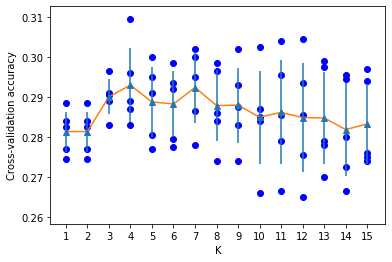

In [55]:
x = range(1,maxK+1)
y = results
for x_axis, y_axis in zip(x, y):
    plt.scatter([x_axis] * len(y_axis), y_axis, c='b')
plt.errorbar(x, mean, std, linestyle='None', marker='^')
plt.plot(x, mean)
plt.xticks(x)
plt.xlabel("K")
plt.ylabel("Cross-validation accuracy")

In [64]:
Chosen_K = 7 # Comparing between 4 and 7: 7 is chosen bec of lower std

In [69]:
#Final Testing
start = time.process_time()
#(a-b)^2 = a^2 - 2.b.a + b^2
a2 = np.sum(training_data_all**2, axis = 1) #(50000,)
b2 = np.sum(testing_data**2, axis = 1) #(10000,)
axbx2 = 2 * np.dot(testing_data, training_data_all.T) #(10000, 50000)
d2 = a2 - axbx2 + b2[:, np.newaxis] #(50000) - (10000, 50000) + (10000) = (10000,50000)
d = np.sqrt(d2)
closest_indexes = d.argsort(axis = 1)[:, :Chosen_K].astype(np.uint16)
closest_labels = training_labels[closest_indexes]
predicted_labels = np.array(list(map(predict_label, closest_labels)))
Accuracy = np.mean(predicted_labels == testing_labels)
print('Model Accuracy = {} \t Elapsed Time = {} secs'.format(Accuracy, time.process_time()-start))

Model Accuracy = 0.3358 	 Elapsed Time = 962.859375 secs
